# Data Prep and Initial Analysis  

#### Step 1: Imports, functions, constants

In [1]:
# Import libraries and dependencies
import os
import requests
import pandas as pd
import yfinance as yf
import csv
from pathlib import Path
import numpy as np

In [2]:
def fetch_yahoo(ticker, start, end):
    
    print(f'Start date = {start}')
    print(f'End date = {end}')   

    # Get Data
    yfObj = yf.Ticker(ticker)
    stock_df = yfObj.history(start=start, end=end)
    # Drop unused columns
    stock_df.drop(['Open', 'Volume', 'Dividends', 'Stock Splits'], inplace=True, axis=1)
    stock_df.rename(columns={'High':'high', 'Low':'low', 'Close':'close'}, inplace=True)
    return stock_df

In [3]:
def validate_data(df):
    print("DATA TYPES:")
    print(df.dtypes)
    print()
    dupes = df.duplicated().sum()
    print(f"Total duplicated values: {dupes}")
    print()
    nulls = df.isnull().sum()
    print(f"Total null values: \n{nulls}")
    

In [4]:
start_date = "1987-01-01"
end_date = "2022-05-01"

#### Step 2: Get data and Validate  

In [5]:
ticker='MSFT'

# Get current closing prices for ticker
stock_df = fetch_yahoo(ticker, start_date, end_date)

# Display sample data
stock_df

Start date = 1987-01-01
End date = 2022-05-01


,high,low,close
Date,,,
1987-01-02,0.106396,0.103668,0.104214
1987-01-05,0.111306,0.103668,0.110215
1987-01-06,0.112398,0.109670,0.111852
1987-01-07,0.117854,0.111852,0.117854
1987-01-08,0.122765,0.118400,0.121673
...,...,...,...
2022-04-25,280.456766,270.140797,280.067688
2022-04-26,277.713172,269.372612,269.592102
2022-04-27,290.293881,278.511326,282.561890


In [6]:
validate_data(stock_df)

DATA TYPES:
high     float64
low      float64
close    float64
dtype: object

Total duplicated values: 31

Total null values: 
high     0
low      0
close    0
dtype: int64


In [7]:
# Save a copy of the clean, raw data
stock_df.to_csv('Resources/msft_hlc.csv')

#### Step 3: Basic Analysis of raw data

In [29]:
stock_df.describe()

,high,low,close
count,504.000000,504.000000,504.000000
mean,256.214966,250.972452,253.701242
std,46.664591,45.966428,46.337750
min,175.006481,170.264928,171.019272
25%,213.028913,209.501507,211.409424
50%,249.348918,245.505308,247.481323
75%,297.189068,292.061736,294.781990
max,348.137633,340.700399,341.606384


<AxesSubplot:>

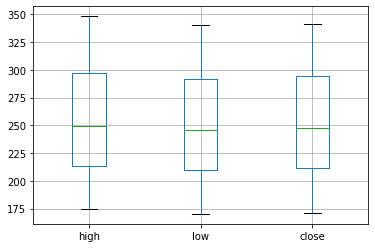

In [30]:
# whisker boxes
stock_df.boxplot(column=['high', 'low', 'close'])

<AxesSubplot:title={'center':'2 Year MSFT Closing Prices'}, xlabel='Date'>

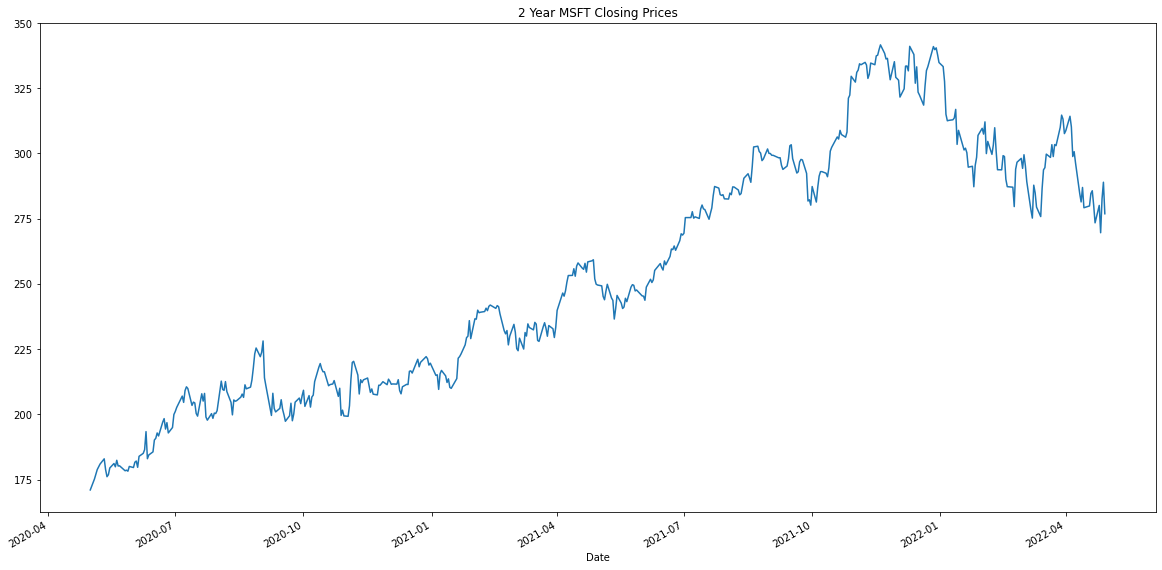

In [31]:
# Plot the close column to examine the trend for closing prices
stock_df['close'].plot(
    title="2 Year MSFT Closing Prices",
    figsize=[20, 10]
)

#### Step 4: Add daily returns, validate, save

In [32]:
stock_df["daily_return"] = stock_df["close"].pct_change()
stock_df = stock_df.dropna()

In [33]:
validate_data(stock_df)

DATA TYPES:
high            float64
low             float64
close           float64
daily_return    float64
dtype: object

Total duplicated values: 0

Total null values: 
high            0
low             0
close           0
daily_return    0
dtype: int64


In [34]:
stock_df.to_csv('Resources/msft_daily.csv')

#### Step 5: Basic Financial Analysis

In [51]:
# Calculate the cumulative returns
cumulative_returns = (1 + stock_df["daily_return"]).cumprod()
cumulative_returns[-1]

1.6189703012664525

The cumulative product of 1.6189703 means that if we bought \\$100,000 worth of MSFT stock at the beginning of our period, we'd have \\$161,897.03 at the end. 

In [52]:
# Set the number of trading days for the year
year_trading_days = 252

# Calculate the annualized average return 
average_annual_return = stock_df["daily_return"].mean() * year_trading_days
average_annual_return

0.2768683395349945

In [54]:
# Calculate the annualized standard deviation
annual_std_dev = stock_df["daily_return"].std() * np.sqrt(year_trading_days)
annual_std_dev

0.26599719164825336

##### Sharpe Ratio  
The Sharpe ratio assesses risk and reward by measuring the excess return (that is, the reward, or profit) for the risk that someone assumes when investing in the asset. The greater the value of the Sharpe ratio, the more attractive the risk-adjusted return for that asset is.

In [38]:
# Calculate Sharpe Ratio by dividing the average annual return by the annual standard deviation
sharpe_ratio = average_annual_return / annual_std_dev
# Display result
sharpe_ratio

1.040869408505323

##### Variance  
Variance measures the price volatility of a single asset around its mean over time.

In [39]:
daily_var = stock_df["daily_return"].var()
daily_var

0.0002807718490664985

A variance of .00028 is low and therefore relatively stable.

In [56]:
ticker='SNP'

# Get current closing prices for M
sp_df = fetch_yahoo(ticker, start_date, end_date)

# Display sample data
sp_daily = sp_df['close'].pct_change().dropna()

sp_daily.tail()

Start date = 2020-05-01
End date = 2022-05-01


Date
2022-04-25   -0.022905
2022-04-26   -0.010076
2022-04-27    0.014125
2022-04-28    0.017001
2022-04-29   -0.019134
Name: close, dtype: float64

In [58]:
sp_cum_return = (1 + sp_daily).cumprod()
sp_cum_return[-1]

1.1994573401673354

The cumulative return for the S&P500 is 1.199457, meaning that if we invested \\$100,000 initially, we'd have $119,945.72.

In [41]:
# Calculate beta of all daily returns
# Divide the covariance versus the S&P 500 by the variance of the S&P 500
beta = stock_df["daily_return"].cov(sp_daily) / sp_daily.var()

# Display the beta
beta

0.07116721674627714

The beta measures how much an asset's return value is likely to change relative to changes in the overall market’s return value. MSFT's beta of .07 means that it will move significantly less than the market.